In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc4
import glob
import datetime as dt
import pickle as pkl
from plot_scripts import plot_TT_pix, plot_layerhist, plot_boxwhisker
from matplotlib.ticker import ScalarFormatter
from plot_ACCLIP_profs import plot_model_overlay, get_ACCLIP_merge_data, get_model_prof_data
import os
import jdcal
import var_config as vc
import hist_utils as util
import csv

In [2]:
def plot_obs_model_compare(ax, var_data, alt_data, CESMSAVEDIR, sims, var_strs, ztype, lon_bnds, lat_bnds, quants, cols, labs, xlim, log=False, MAM_corr = False):

    if MAM_corr == True: 
        var_mods = [vc.var_info['so4_a1']['mod'],vc.var_info['so4_a2']['mod'],vc.var_info['so4_a3']['mod']]
    else: 
        var_mods = [vc.var_info[var_strs[0]]['mod']]
        
    var_lab = vc.var_info[var_strs[0]]['lab']
    unit = vc.var_info[var_strs[0]]['unit']
    
    ax.scatter(var_data, alt_data, color=[0.6,0.6,0.6], s=0.1,)
    
    for s in range(len(sims)):

        if MAM_corr == True: lev_z, model_mean, model_lowq, model_upq = get_model_prof_data(CESMSAVEDIR, ['so4_a1','so4_a2','so4_a3'], ztype, sims[s], lon_bnds, lat_bnds, 100, quants, var_mods)
        else: lev_z, model_mean, model_lowq, model_upq = get_model_prof_data(CESMSAVEDIR, var_strs, ztype, sims[s], lon_bnds, lat_bnds, 100, quants, var_mods)

        ax.fill_betweenx(lev_z, model_lowq, model_upq, facecolor=cols[s], alpha=0.3)          
        ax.plot(model_mean, lev_z, color=cols[s], linewidth = 2, label=labs[s])    # 'MAM4 - CAMS SO2'      

    z_bins = (lev_z[0:-1] + lev_z[1:])/2.
    #obs_mean = []
    #lev_z_obs = []
    
    for bin in range(len(z_bins)-1):
        bin_min = z_bins[bin]
        bin_max = z_bins[bin+1]

        curr_z = (bin_min + bin_max)/2.
        #lev_z_obs.append()

        curr_obs = []
        for pt in range(len(var_data)):
            curr_alt = alt_data[pt]
            if curr_alt >= bin_min and curr_alt <= bin_max and var_data[pt] > -100:
                curr_obs.append(var_data[pt])

        if len(curr_obs) > 0:
            ax.scatter(np.nanmean(curr_obs), curr_z, color='k', s=10)
            ax.plot([np.nanpercentile(curr_obs, quants[0]),np.nanpercentile(curr_obs, quants[1])],[curr_z, curr_z], color='k', linewidth=1)
            
        #if len(curr_obs) > 0: obs_mean.append(np.nanmean(curr_obs))
        #else: obs_mean.append(np.nan)

    #ax.plot(obs_mean, lev_z_obs, color='k', linewidth=2, label='ACCLIP (2022) Obs')

    ax.set_xlim(xlim)
    if log == True: ax.set_xscale('log')
    ax.set_ylim([6,20])
    #ax.set_yticks([2,6,10,14,18])

    ax.set_xlabel(var_lab + ' (' + unit + ')', fontsize=14)
    if ztype == 'z': ax.set_ylabel('Altitude (km)', fontsize=14)

    # Later addition: add a layer marker for 12-15km 
    ax.fill_between([0,1000],[12,12],[15,15],color=[0.9,0.9,0.9],alpha=0.5,zorder=0)

    ax.legend(fontsize=12)

    for label in ax.get_xticklabels():
        label.set_fontsize(14)
    for label in ax.get_yticklabels():
        label.set_fontsize(14)
        
def get_model_pcts_SO2(SAVEDIR, var_str, lon_bnds, lat_bnds, z_rng):

    var_MAM4_MEIC = util.model_alt_subset(SAVEDIR, var_str, 'MAM4_MEIC_SO2', lon_bnds, lat_bnds, z_rng, vc.var_info[var_str]['mod'])
    var_MAM4_CAMS = util.model_alt_subset(SAVEDIR, var_str, 'MAM4_CAMS6.2_SO2', lon_bnds, lat_bnds, z_rng, vc.var_info[var_str]['mod'])
    var_CARMA_MEIC = util.model_alt_subset(SAVEDIR, var_str, 'CARMA_MEIC_SO2_bins', lon_bnds, lat_bnds, z_rng, vc.var_info[var_str]['mod'])
    var_CARMA_CAMS = util.model_alt_subset(SAVEDIR, var_str, 'CARMA_CAMS_SO2_bins', lon_bnds, lat_bnds, z_rng, vc.var_info[var_str]['mod'])
    
    var_pcts_MAM4_MEIC_domavg = util.get_percentiles(var_MAM4_MEIC, [5,25,50,75,95])
    var_pcts_MAM4_CAMS_domavg = util.get_percentiles(var_MAM4_CAMS, [5,25,50,75,95])
    var_pcts_CARMA_MEIC_domavg = util.get_percentiles(var_CARMA_MEIC, [5,25,50,75,95])
    var_pcts_CARMA_CAMS_domavg = util.get_percentiles(var_CARMA_CAMS, [5,25,50,75,95])

    return var_pcts_MAM4_MEIC_domavg, var_pcts_MAM4_CAMS_domavg, var_pcts_CARMA_MEIC_domavg, var_pcts_CARMA_CAMS_domavg, np.mean(var_MAM4_MEIC), np.mean(var_MAM4_CAMS), np.mean(var_CARMA_MEIC), np.mean(var_CARMA_CAMS)

def get_model_pcts_SO4(SAVEDIR, var_str, lon_bnds, lat_bnds, z_rng):

    # This is done to weight the different bins according to what could have been sampled by ERICA.  Different var_mods in the config file
    a1_MAM4_MEIC = util.model_alt_subset(SAVEDIR, 'so4_a1', 'MAM4_MEIC_SO2', lon_bnds, lat_bnds, z_rng, vc.var_info['so4_a1']['mod'])
    a2_MAM4_MEIC = util.model_alt_subset(SAVEDIR, 'so4_a2', 'MAM4_MEIC_SO2', lon_bnds, lat_bnds, z_rng, vc.var_info['so4_a2']['mod'])
    a3_MAM4_MEIC = util.model_alt_subset(SAVEDIR, 'so4_a3', 'MAM4_MEIC_SO2', lon_bnds, lat_bnds, z_rng, vc.var_info['so4_a3']['mod'])
    var_MAM4_MEIC = a1_MAM4_MEIC + a2_MAM4_MEIC + a3_MAM4_MEIC

    a1_MAM4_CAMS = util.model_alt_subset(SAVEDIR, 'so4_a1', 'MAM4_CAMS6.2_SO2', lon_bnds, lat_bnds, z_rng, vc.var_info['so4_a1']['mod'])
    a2_MAM4_CAMS = util.model_alt_subset(SAVEDIR, 'so4_a2', 'MAM4_CAMS6.2_SO2', lon_bnds, lat_bnds, z_rng, vc.var_info['so4_a2']['mod'])
    a3_MAM4_CAMS = util.model_alt_subset(SAVEDIR, 'so4_a3', 'MAM4_CAMS6.2_SO2', lon_bnds, lat_bnds, z_rng, vc.var_info['so4_a3']['mod'])
    var_MAM4_CAMS = a1_MAM4_CAMS + a2_MAM4_CAMS + a3_MAM4_CAMS
    
    var_CARMA_MEIC = util.model_alt_subset(SAVEDIR, var_str, 'CARMA_MEIC_SO2_bins_binsub', lon_bnds, lat_bnds, z_rng, vc.var_info[var_str]['mod'])
    var_CARMA_CAMS = util.model_alt_subset(SAVEDIR, var_str, 'CARMA_CAMS_SO2_bins_binsub', lon_bnds, lat_bnds, z_rng, vc.var_info[var_str]['mod'])
    
    var_pcts_MAM4_MEIC_domavg = util.get_percentiles(var_MAM4_MEIC, [5,25,50,75,95])
    var_pcts_MAM4_CAMS_domavg = util.get_percentiles(var_MAM4_CAMS, [5,25,50,75,95])
    var_pcts_CARMA_MEIC_domavg = util.get_percentiles(var_CARMA_MEIC, [5,25,50,75,95])
    var_pcts_CARMA_CAMS_domavg = util.get_percentiles(var_CARMA_CAMS, [5,25,50,75,95])

    return var_pcts_MAM4_MEIC_domavg, var_pcts_MAM4_CAMS_domavg, var_pcts_CARMA_MEIC_domavg, var_pcts_CARMA_CAMS_domavg, np.mean(var_MAM4_MEIC), np.mean(var_MAM4_CAMS), np.mean(var_CARMA_MEIC), np.mean(var_CARMA_CAMS)
    

In [3]:

# Define the relevant paths
GV_OBSROOT = '/glade/work/wsmith/ACCLIP_GV_R1_60SEC_Merge/'
WB_OBSROOT = '/glade/work/wsmith/ACCLIP_WB57_R1_60SEC_Merge/'
ERICA_OBSROOT = '/glade/work/wsmith/ACCLIP_GV_R1_ERICA_Merge/'
PLOTDIR = '/glade/u/home/wsmith/ASM_SO4_scripts/plots/'
CESMSAVEDIR = '/glade/derecho/scratch/wsmith/carma_vars/'

GV_FLT_DATES = ['20220730','20220804','20220806','20220807','20220812','20220815','20220816','20220819','20220822','20220823','20220825','20220826','20220829','20220830']
ERICA_FLT_DATES = ['20220804','20220806','20220807','20220812','20220815','20220816','20220819','20220822','20220823','20220825','20220826']
WB_FLT_DATES = ['20220802','20220804','20220806','20220812','20220813','20220815','20220816','20220819','20220821','20220823','20220825','20220826','20220829','20220831','20220901']

ACCLIP_GV_z  = get_ACCLIP_merge_data(GV_OBSROOT, GV_FLT_DATES, 'GGALT')*1.e-3
ACCLIP_WB_z  = get_ACCLIP_merge_data(WB_OBSROOT, WB_FLT_DATES, 'G_ALT_MMS')*1.e-3
ACCLIP_z = np.asarray(list(ACCLIP_GV_z) + list(ACCLIP_WB_z))

ACCLIP_GV_SO2 = get_ACCLIP_merge_data(GV_OBSROOT, GV_FLT_DATES, 'SO2_GTCIMS') 
ACCLIP_WB_SO2 = get_ACCLIP_merge_data(WB_OBSROOT, WB_FLT_DATES, 'SO2_LIF')
ACCLIP_WB_OCS = get_ACCLIP_merge_data(WB_OBSROOT, WB_FLT_DATES, 'ACOS_OCS_PPT')
ACCLIP_SO2 = np.asarray(list(ACCLIP_GV_SO2) + list(ACCLIP_WB_SO2))

ACCLIP_ERICA_SO4_raw = get_ACCLIP_merge_data(ERICA_OBSROOT, ERICA_FLT_DATES, 'sulphate_AMS')   # Raw units of ug/m3  
ACCLIP_GV_ERICA_z_raw = get_ACCLIP_merge_data(ERICA_OBSROOT, ERICA_FLT_DATES, 'GGALT')*1.e-3 

ACCLIP_GV_CO = get_ACCLIP_merge_data(GV_OBSROOT, GV_FLT_DATES, 'CO_AERODYNE') 
ACCLIP_WB_CO = get_ACCLIP_merge_data(WB_OBSROOT, WB_FLT_DATES, 'CO_COLD2_ppbv')
ACCLIP_CO = np.asarray(list(ACCLIP_GV_CO) + list(ACCLIP_WB_CO))

ACCLIP_GV_O3 = get_ACCLIP_merge_data(GV_OBSROOT, GV_FLT_DATES, 'O3_ppbv') 
ACCLIP_WB_O3 = get_ACCLIP_merge_data(WB_OBSROOT, WB_FLT_DATES, 'O3_ppb')
ACCLIP_O3 = np.asarray(list(ACCLIP_GV_O3) + list(ACCLIP_WB_O3))

aer_conv = 1013.*100.*1e9/(273.*286.9969)

#lon_bnds = [125,150]    # Bigger ACCLIP box
#lat_bnds = [20,40] 

lon_bnds = [125,140]     # Standard ACCLIP box
lat_bnds = [25,38]

#lon_bnds = [75,120]      # EASM box
#lat_bnds = [25,40]

z_rng = [12,15]


In [4]:

# For the ERICA observations, remove points below the detection limit.  
ERICA_SO4_detlim = 0.001 # Detection limit provided by Oliver Eppers in May 2025

ACCLIP_ERICA_SO4 = []
ACCLIP_GV_ERICA_z = []

for pt in range(len(ACCLIP_ERICA_SO4_raw)):
    if ACCLIP_ERICA_SO4_raw[pt] >= ERICA_SO4_detlim: 
        ACCLIP_ERICA_SO4.append(ACCLIP_ERICA_SO4_raw[pt])
        ACCLIP_GV_ERICA_z.append(ACCLIP_GV_ERICA_z_raw[pt])


In [5]:

# Read the rough calculation of sulfate from the WB-57 (courtesy of Gregg Schill)
WB_SO4_file = '/glade/work/wsmith/rough_calc_sulfate_total_v2.csv'

WB_SO4_mean = []
WB_SO4_z = []

with open(WB_SO4_file, 'r', newline='') as csvfile:
    reader = csv.reader(csvfile)
    for i, row in enumerate(reader):
        if i > 0:  # Skip the title row 

            # Use these below settings for the first version of the file
            #WB_SO4_mean.append(float(row[0]))
            #WB_SO4_z.append(float(row[3])*1.e-3)

            # Use these below settings for v2 file
            WB_SO4_mean.append(float(row[2]))
            WB_SO4_z.append(float(row[4])*1.e-3)            

print(np.min(WB_SO4_mean), np.max(WB_SO4_mean))
print(np.min(WB_SO4_z), np.max(WB_SO4_z))            


0.095227 9.60861
0.18928299999999998 18.9567


In [6]:

# Read in info for the UTLS histograms

SO4_ACCLIP = util.obs_alt_subset(ERICA_OBSROOT, ERICA_FLT_DATES, 'sulphate_AMS', 'GGALT', z_rng, 0.001)  # Detection limit from Oliver Eppers for 12-15km layer, May 2025
SO4_ACCLIP_pcts = util.get_percentiles(SO4_ACCLIP, [5,25,50,75,95])

SO2_GV = util.obs_alt_subset(GV_OBSROOT, GV_FLT_DATES, 'SO2_GTCIMS', 'GGALT', z_rng, -100)
SO2_WB = util.obs_alt_subset(WB_OBSROOT, WB_FLT_DATES, 'SO2_LIF', 'G_ALT_MMS', z_rng, -100)
SO2_ACCLIP = SO2_GV + SO2_WB
SO2_ACCLIP_pcts = util.get_percentiles(SO2_ACCLIP, [5,25,50,75,95])

# Get the model information to match the observations
SO4_pcts_MAM4_MEIC_domavg, SO4_pcts_MAM4_CAMS_domavg, SO4_pcts_CARMA_MEIC_domavg, SO4_pcts_CARMA_CAMS_domavg, SO4_mean_MAM4_MEIC, SO4_mean_MAM4_CAMS, SO4_mean_CARMA_MEIC, SO4_mean_CARMA_CAMS = get_model_pcts_SO4(CESMSAVEDIR, 'SO4', lon_bnds, lat_bnds, z_rng)
SO2_pcts_MAM4_MEIC_domavg, SO2_pcts_MAM4_CAMS_domavg, SO2_pcts_CARMA_MEIC_domavg, SO2_pcts_CARMA_CAMS_domavg, SO2_mean_MAM4_MEIC, SO2_mean_MAM4_CAMS, SO2_mean_CARMA_MEIC, SO2_mean_CARMA_CAMS = get_model_pcts_SO2(CESMSAVEDIR, 'SO2', lon_bnds, lat_bnds, z_rng)

#print(SO4_mean_MAM4_MEIC)
#print(SO4_mean_CARMA_MEIC)
#print(np.mean(SO4_ACCLIP))

print(SO2_mean_MAM4_MEIC)
print(SO2_mean_CARMA_MEIC)
print(SO2_mean_MAM4_CAMS)
print(SO2_mean_CARMA_CAMS)
print(np.mean(SO2_ACCLIP))


46.57908766883699
54.56264612436996
74.61651056420362
89.12886972358868
33.799139399460195


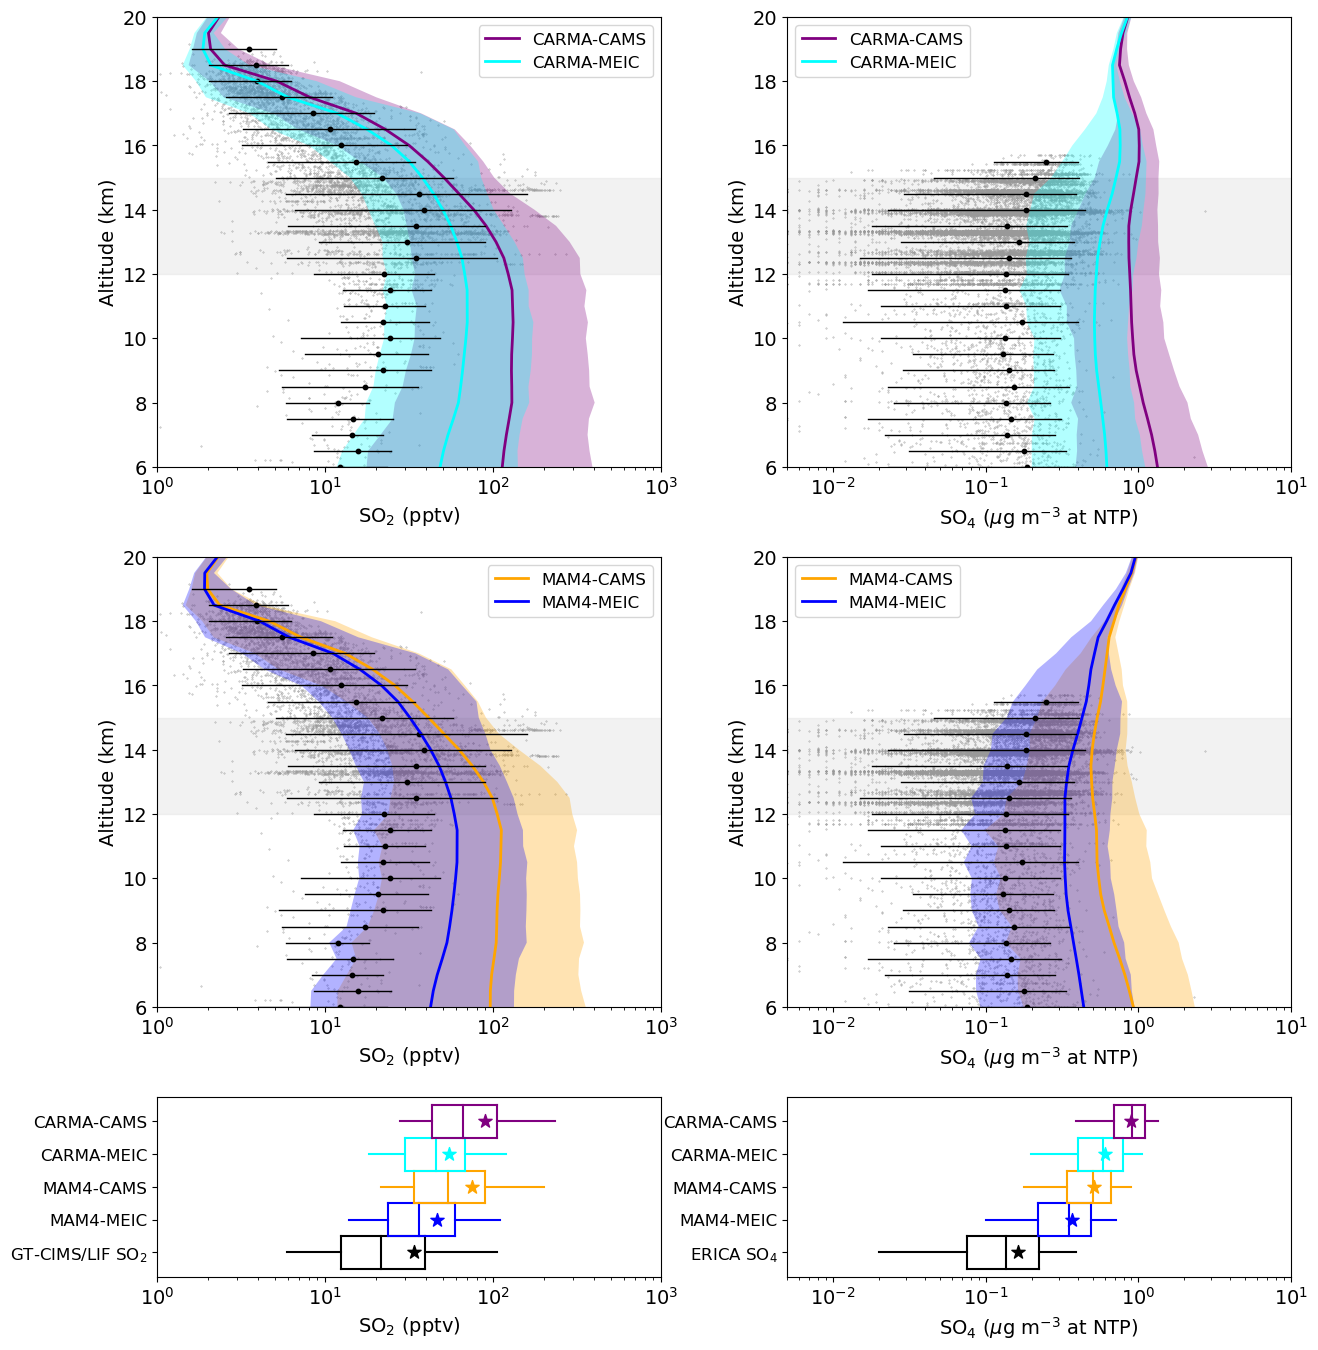

In [7]:
    
# Make a plot 

fig = plt.figure(figsize=(14,18))

ax1  = plt.subplot(3,2,1)
ax2  = plt.subplot(3,2,2)
ax3  = plt.subplot(3,2,3)
ax4  = plt.subplot(3,2,4)
ax5  = plt.subplot(3,2,5)
ax6  = plt.subplot(3,2,6)

ax1.set_position([0.15,0.7,0.36,0.25])
ax2.set_position([0.6,0.7,0.36,0.25])
ax3.set_position([0.15,0.4,0.36,0.25])
ax4.set_position([0.6,0.4,0.36,0.25])
ax5.set_position([0.15,0.25,0.36,0.10])   # Unclear why these have to be switched... but we do we must for the good of the plot
ax6.set_position([0.6,0.25,0.36,0.10])

pcts = [5,95]

plot_obs_model_compare(ax1, ACCLIP_SO2, ACCLIP_z, CESMSAVEDIR, ['CARMA_CAMS_SO2','CARMA_MEIC_SO2'], ['SO2'], 'z', lon_bnds, lat_bnds, pcts, ['purple','cyan'], ['CARMA-CAMS', 'CARMA-MEIC'], [1,1000], log=True)  # [0,250]
plot_obs_model_compare(ax2, ACCLIP_ERICA_SO4, ACCLIP_GV_ERICA_z, CESMSAVEDIR, ['CARMA_CAMS_SO2_bins_binsub','CARMA_MEIC_SO2_bins_binsub'], ['SO4'], 'z', lon_bnds, lat_bnds, pcts, ['purple','cyan'], ['CARMA-CAMS','CARMA-MEIC'], [0.005,10], log=True)  # [0,2]
plot_obs_model_compare(ax3, ACCLIP_SO2, ACCLIP_z, CESMSAVEDIR, ['MAM4_CAMS6.2_SO2','MAM4_MEIC_SO2'], ['SO2'], 'z', lon_bnds, lat_bnds, pcts, ['orange','blue'], ['MAM4-CAMS', 'MAM4-MEIC'], [1,1000], log=True)
plot_obs_model_compare(ax4, ACCLIP_ERICA_SO4, ACCLIP_GV_ERICA_z, CESMSAVEDIR, ['MAM4_CAMS6.2_SO2','MAM4_MEIC_SO2'], ['SO4'], 'z', lon_bnds, lat_bnds, pcts, ['orange','blue','red'], ['MAM4-CAMS', 'MAM4-MEIC', '110L'], [0.005,10], log=True, MAM_corr=True)
#plt.tight_layout() 

#ax2.plot(WB_SO4_mean, WB_SO4_z, color=[0.8,0.8,0.8], linestyle='dashed', linewidth=2)
#ax4.plot(WB_SO4_mean, WB_SO4_z, color=[0.8,0.8,0.8], linestyle='dashed', linewidth=2)

util.box_plot(ax5, SO2_ACCLIP_pcts, np.mean(SO2_ACCLIP), 1.1, 'black', '*')
util.box_plot(ax5, SO2_pcts_MAM4_MEIC_domavg, SO2_mean_MAM4_MEIC, 1.2, 'blue', '*')
util.box_plot(ax5, SO2_pcts_MAM4_CAMS_domavg, SO2_mean_MAM4_CAMS, 1.3, 'orange', '*')
util.box_plot(ax5, SO2_pcts_CARMA_MEIC_domavg, SO2_mean_CARMA_MEIC, 1.4, 'cyan', '*')
util.box_plot(ax5, SO2_pcts_CARMA_CAMS_domavg, SO2_mean_CARMA_CAMS, 1.5, 'purple', '*')

util.box_plot(ax6, SO4_ACCLIP_pcts, np.mean(SO4_ACCLIP), 1.1, 'black', '*')
util.box_plot(ax6, SO4_pcts_MAM4_MEIC_domavg, SO4_mean_MAM4_MEIC, 1.2, 'blue', '*')
util.box_plot(ax6, SO4_pcts_MAM4_CAMS_domavg, SO4_mean_MAM4_CAMS, 1.3, 'orange', '*')
util.box_plot(ax6, SO4_pcts_CARMA_MEIC_domavg, SO4_mean_CARMA_MEIC, 1.4, 'cyan', '*')
util.box_plot(ax6, SO4_pcts_CARMA_CAMS_domavg, SO4_mean_CARMA_CAMS, 1.5, 'purple', '*')

ax5.set_yticks([1.1,1.2,1.3,1.4,1.5])
ax5.set_yticklabels([vc.var_info['SO2']['instrument'] + ' ' + vc.var_info['SO2']['lab'],'MAM4-MEIC','MAM4-CAMS','CARMA-MEIC','CARMA-CAMS'])
ax5.set_xlabel(vc.var_info['SO2']['lab'] + ' (' + vc.var_info['SO2']['unit'] + ')', fontsize=14)

for label in ax5.get_xticklabels():
    label.set_fontsize(14)
for label in ax5.get_yticklabels():
    label.set_fontsize(12)

ax6.set_yticks([1.1,1.2,1.3,1.4,1.5])
ax6.set_yticklabels([vc.var_info['SO4']['instrument'] + ' ' + vc.var_info['SO4']['lab'],'MAM4-MEIC','MAM4-CAMS','CARMA-MEIC','CARMA-CAMS'])
ax6.set_xlabel(vc.var_info['SO4']['lab'] + ' (' + vc.var_info['SO4']['unit'] + ')', fontsize=14)

for label in ax6.get_xticklabels():
    label.set_fontsize(14)
for label in ax6.get_yticklabels():
    label.set_fontsize(12)
    
ax5.set_xscale('log')
ax6.set_xscale('log')

ax5.set_xlim([1,1000])
ax6.set_xlim([0.005,10])

plt.savefig(PLOTDIR + 'Figure1.png', dpi=300)
plt.savefig(PLOTDIR + 'Figure1.pdf', dpi=300)
#plt.close('all')


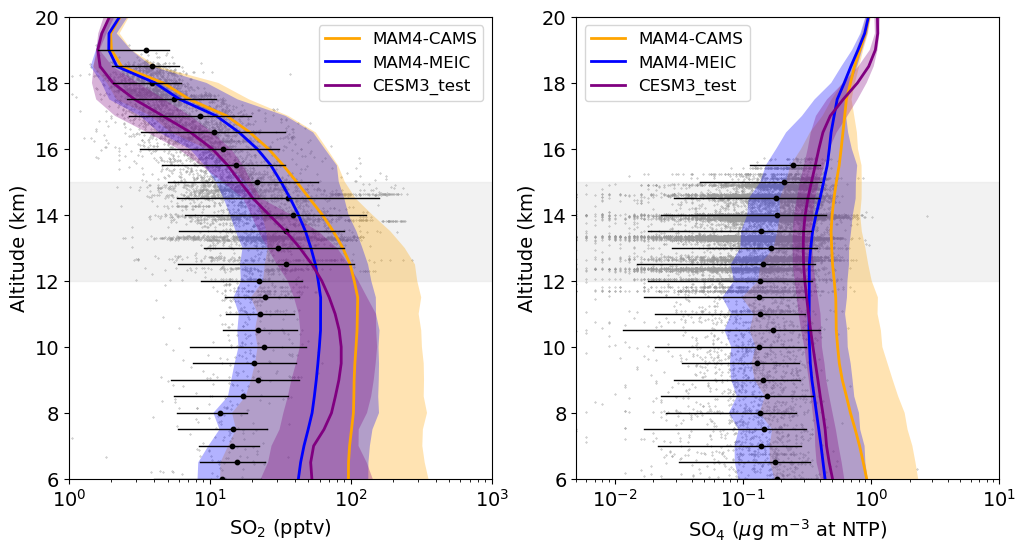

In [14]:

## Another plot configuration, designed to test sensitivity to the subset of bins

fig = plt.figure(figsize=(12,6))
    
ax1  = plt.subplot(1,2,1)    
ax2  = plt.subplot(1,2,2)

#plot_obs_model_compare(ax1, ACCLIP_ERICA_SO4, ACCLIP_GV_ERICA_z, CESMSAVEDIR, ['CARMA_MEIC_SO2_bins','CARMA_MEIC_SO2_bins_binsub'], 'SO4', 'z', [125,150], [20,40], pcts, ['purple','red'], ['CARMA_MEIC','CARMA_MEIC_BinSub'], [0,2], log=False)

plot_obs_model_compare(ax1, ACCLIP_SO2, ACCLIP_z, CESMSAVEDIR, ['MAM4_CAMS6.2_SO2','MAM4_MEIC_SO2','MAM4_CESM3_test'], ['SO2'], 'z', lon_bnds, lat_bnds, pcts, ['orange','blue','purple'], ['MAM4-CAMS', 'MAM4-MEIC','CESM3_test'], [1,1000], log=True)
plot_obs_model_compare(ax2, ACCLIP_ERICA_SO4, ACCLIP_GV_ERICA_z, CESMSAVEDIR, ['MAM4_CAMS6.2_SO2','MAM4_MEIC_SO2','MAM4_CESM3_test'], ['SO4'], 'z', lon_bnds, lat_bnds, pcts, ['orange','blue','purple'], ['MAM4-CAMS', 'MAM4-MEIC', 'CESM3_test'], [0.005,10], log=True, MAM_corr=True)


In [ ]:

## Another plot configuration, designed to test sensitivity to the subset of bins

fig = plt.figure(figsize=(14,12))
    
ax1  = plt.subplot(1,1,1)    

plot_obs_model_compare(ax1, ACCLIP_ERICA_SO4, ACCLIP_GV_ERICA_z, CESMSAVEDIR, ['CARMA_MEIC_SO2_Aug22','CARMA_MEIC_SO2_Aug22_0.9um','CARMA_MEIC_SO2_Aug22_1.2um'], 'SO4', 'z', [125,150], [20,40], pcts, ['red',[0.8,0.8,0.8],[0.5,0.5,0.5]], ['CARMA_MEIC_0.06um', 'CARMA_MEIC_0.09um','CARMA_MEIC_0.12um'], [0.01,10], log=True)


In [ ]:

## Another plot configuration, for OCS comparison

fig = plt.figure(figsize=(14,12))
    
ax1  = plt.subplot(1,1,1)    

pcts=[1,99]
plot_obs_model_compare(ax1, ACCLIP_WB_OCS, ACCLIP_WB_z, CESMSAVEDIR, ['MAM4_CAMS6.2_SO2','MAM4_MEIC_SO2'], 'OCS', 'z', [125,150], [20,40], pcts, ['orange','blue'], ['MAM4_CAMS', 'MAM4_MEIC'], [0,1000], log=False)



In [ ]:
## Another plot configuration
#
#fig = plt.figure(figsize=(14,12))
#    
#ax1  = plt.subplot(2,2,1)    
#ax2  = plt.subplot(2,2,2) 
#ax3  = plt.subplot(2,2,3) 
#ax4  = plt.subplot(2,2,4) 
#
#plot_obs_model_compare(ax1, ACCLIP_SO2, ACCLIP_z, CESMSAVEDIR, ['CARMA_CAMS_SO2','CARMA_MEIC_SO2'], 'SO2', 'z', lon_bnds, lat_bnds, [5,95], ['purple','cyan'], ['CARMA, CAMS SO$_2$', 'CARMA, MEIC SO$_2$'], [1,1000], log=True)
#plot_obs_model_compare(ax2, ACCLIP_ERICA_SO4, ACCLIP_GV_ERICA_z, CESMSAVEDIR, ['CARMA_CAMS_SO2','CARMA_MEIC_SO2'], 'SO4', 'z', lon_bnds, lat_bnds, [5,95], ['purple','cyan'], ['CARMA, CAMS SO$_2$', 'CARMA, MEIC SO$_2$'], [0.01,10], log=True)
#plot_obs_model_compare(ax3, ACCLIP_SO2, ACCLIP_z, CESMSAVEDIR, ['MAM4_CAMS6.2_SO2','MAM4_MEIC_SO2','MAM4_MEIC_SO2_ZMKE'], 'SO2', 'z', lon_bnds, lat_bnds, [5,95], ['orange','blue','red'], ['MAM4, CAMS SO$_2$', 'MAM4, MEIC SO$_2$','MAM4 ZMKE, MEIC SO$_2$'], [1,1000], log=True)
#plot_obs_model_compare(ax4, ACCLIP_ERICA_SO4, ACCLIP_GV_ERICA_z, CESMSAVEDIR, ['MAM4_CAMS6.2_SO2','MAM4_MEIC_SO2','MAM4_MEIC_SO2_ZMKE'], 'SO4', 'z', lon_bnds, lat_bnds, [5,95], ['orange','blue','red'], ['MAM4, CAMS SO$_2$','MAM4, MEIC SO$_2$','MAM4 ZMKE, MEIC SO$_2$'], [0,3], log=False)

In [ ]:
## Another plot configuration
#
#lon_bnds = [90,110]
#lat_bnds = [25,40]
#
#fig = plt.figure(figsize=(14,12))
#    
#ax1  = plt.subplot(2,2,1) 
#ax2  = plt.subplot(2,2,2) 
#ax3  = plt.subplot(2,2,3) 
#ax4  = plt.subplot(2,2,4) 
#
#plot_obs_model_compare(ax1, ACCLIP_SO2, ACCLIP_z, CESMSAVEDIR, ['MAM4_MEIC_SO2','MAM4_MEIC_SO2_ZMKE'],\
#                       'SO2', 'z', lon_bnds, lat_bnds, [5,95], ['blue','purple'],\
#                       ['MAM4 MEIC','MAM4 MEIC ZMKE'], [1,1000], log=True)
#plot_obs_model_compare(ax2, ACCLIP_ERICA_SO4, ACCLIP_GV_ERICA_z, CESMSAVEDIR, ['MAM4_MEIC_SO2','MAM4_MEIC_SO2_ZMKE'], \
#                       'SO4', 'z', lon_bnds, lat_bnds, [5,95], ['blue','purple'],\
#                       ['MAM4 MEIC','MAM4 MEIC ZMKE'], [0.01,10], log=True)
#plot_obs_model_compare(ax3, ACCLIP_CO, ACCLIP_z, CESMSAVEDIR, ['MAM4_MEIC_SO2','MAM4_MEIC_SO2_ZMKE'],\
#                       'CO', 'z', lon_bnds, lat_bnds, [5,95], ['blue','purple'],\
#                       ['MAM4 MEIC','MAM4 MEIC ZMKE'], [0,350])
#plot_obs_model_compare(ax4, ACCLIP_O3, ACCLIP_z, CESMSAVEDIR, ['MAM4_MEIC_SO2','MAM4_MEIC_SO2_ZMKE'],\
#                       'O3', 'z', lon_bnds, lat_bnds, [5,95], ['blue','purple'],\
#                       ['MAM4 MEIC','MAM4 MEIC ZMKE'], [1,2000], log=True)

In [ ]:






##### Below is the archaeic way we used to do this

    
    ##### Make SO4 profile plot


    #
    #fig = plt.figure()
    #ax1  = plt.subplot(1,1,1)
    #plot_model_overlay(ax1, ACCLIP_ERICA_SO4, np.logspace(-2,1,num=50), [0.01,10], 'SO4', 'SO4', lon_bnds, lat_bnds, ACCLIP_ERICA_z, [0], 'z', 18, [0.75,20], [5,95], 7, 'Altitude (km)', [0,5,10,15,20], \
    #                   'ug/m3', 0, 1, CESMSAVEDIR, PLOTDIR, aer_conv, do_modelpix=0)  ##### ALTITUDE, LOG SCALE   
    ##plot_model_overlay(ax1, ACCLIP_ERICA_SO4, np.arange(0,6.01,0.25), [0,6], 'SO4', 'SO4', [125,140], [25,38], ACCLIP_ERICA_z, [0], 'z', 18, [2,20], [5,95], 6, 'Altitude (km)', [0,5,10,15,20], \
    ##                   'ug/m3', 0, 0, CESMSAVEDIR, PLOTDIR, aer_conv, do_modelpix=0)  ##### ALTITUDE, LINEAR SCALE
    #plt.legend()
    #plt.tight_layout()
    #plt.savefig(PLOTDIR + 'SO4_Figure_' + str(lon_bnds) + '_' + str(lat_bnds) + '.png', dpi=300)
    ##plt.close('all')   

    ##### Make OA profile plot

    ##ACCLIP_ERICA_z = get_ACCLIP_merge_data(ERICA_OBSROOT, ERICA_FLT_DATES, 'GGALT')*1.e-3 
    #ACCLIP_ERICA_OA = get_ACCLIP_merge_data(ERICA_OBSROOT, ERICA_FLT_DATES, 'organics_AMS')   # Raw units of ug/m3
    #
    #fig = plt.figure()
    #ax1  = plt.subplot(1,1,1)
    #plot_model_overlay(ax1, ACCLIP_ERICA_OA, np.logspace(-2,1,num=50), [0.01,10], 'OA', 'OA', lon_bnds, lat_bnds, ACCLIP_ERICA_z, [0], 'z', 18, [0.75,20], [5,95], 7, 'Altitude (km)', [0,5,10,15,20], \
    #                   'ug/m3', 0, 1, CESMSAVEDIR, PLOTDIR, aer_conv, do_modelpix=0)  ##### ALTITUDE, LOG SCALE   
    ##plot_model_overlay(ax1, ACCLIP_ERICA_SO4, np.arange(0,6.01,0.25), [0,6], 'SO4', 'SO4', [125,140], [25,38], ACCLIP_ERICA_z, [0], 'z', 18, [2,20], [5,95], 6, 'Altitude (km)', [0,5,10,15,20], \
    ##                   'ug/m3', 0, 0, CESMSAVEDIR, PLOTDIR, aer_conv, do_modelpix=0)  ##### ALTITUDE, LINEAR SCALE
    #plt.legend()
    #plt.tight_layout()
    #plt.savefig(PLOTDIR + 'OA_Figure_' + str(lon_bnds) + '_' + str(lat_bnds) + '.png', dpi=300)
    ##plt.close('all')   
    
    ##### Make SO2 profile plot


    
    #plot_model_overlay(ax1, ACCLIP_SO2, np.logspace(0,3,num=50), [1,1000], 'SO2', 'SO2', lon_bnds, lat_bnds, ACCLIP_z, [0], 'z', 18, [0.75,20], [5,95], 7, 'Altitude (km)', [0,5,10,15,20], \
    #                   'pptv', 0, 1, CESMSAVEDIR, PLOTDIR, 1e12, do_modelpix=0)  ##### ALTITUDE    



    ##### Make CO profile plot
    

    #
    #fig = plt.figure()
    #ax1  = plt.subplot(1,1,1)    
    #plot_model_overlay(ax1, ACCLIP_CO, np.arange(0,350,10), [0,350], 'CO', 'CO', lon_bnds, lat_bnds, ACCLIP_z, [0], 'z', 18, [0.75,20], [5,95], 7, 'Altitude (km)', [0,5,10,15,20], \
    #                   'ppbv', 0, 0, CESMSAVEDIR, PLOTDIR, 1e9, do_modelpix=0)  ##### ALTITUDE    
    #plt.legend()
    #plt.tight_layout()       
    #plt.savefig(PLOTDIR + 'CO_Figure_' + str(lon_bnds) + '_' + str(lat_bnds) + '.png', dpi=300)
    ##plt.close('all')

    ##### Make O3 profile plot
    

    #
    #fig = plt.figure()
    #ax1  = plt.subplot(1,1,1)    
    #plot_model_overlay(ax1, ACCLIP_O3, np.logspace(0,3,num=50), [1,1000], 'O3', 'O3', lon_bnds, lat_bnds, ACCLIP_z, [0], 'z', 18, [0.75,20], [5,95], 7, 'Altitude (km)', [0,5,10,15,20], \
    #                   'ppbv', 0, 1, CESMSAVEDIR, PLOTDIR, 1e9, do_modelpix=0)  ##### ALTITUDE    
    #plt.legend()
    #plt.tight_layout()       
    #plt.savefig(PLOTDIR + 'O3_Figure_' + str(lon_bnds) + '_' + str(lat_bnds) + '.png', dpi=300)
    ##plt.close('all')

    ##### Make BC profile plot
    
    #ACCLIP_GV_SP2_BC = get_ACCLIP_merge_data(GV_OBSROOT, GV_FLT_DATES, 'BC_mass_90_550_nm_std_SP2')*1.e-3   # Convert from ng/m3 to ug/m3  
    #ACCLIP_WB_SP2_BC = get_ACCLIP_merge_data(WB_OBSROOT, WB_FLT_DATES, 'BC_mass_90_550_nm_std')*1.e-3
    #ACCLIP_SP2_BC = np.asarray(list(ACCLIP_GV_SP2_BC) + list(ACCLIP_WB_SP2_BC))
    #
    #fig = plt.figure()
    #ax1  = plt.subplot(1,1,1)
    #plot_model_overlay(ax1, ACCLIP_SP2_BC, np.logspace(-4,0,num=50), [0.0001,1], 'BC', 'BC', lon_bnds, lat_bnds, ACCLIP_z, [0], 'z', 18, [0.75,20], [5,95], 7, 'Altitude (km)', [0,5,10,15,20], \
    #                   'ug/m3', 0, 1, CESMSAVEDIR, PLOTDIR, aer_conv, do_modelpix=0)  ##### ALTITUDE    
    #plt.legend()
    #plt.tight_layout()
    #plt.savefig(PLOTDIR + 'BC_Figure_' + str(lon_bnds) + '_' + str(lat_bnds) + '.png', dpi=300)
    ##plt.close('all')   
    